In [1]:
# A very simple data structure representing a directed graph, with the ability to
# label and color the nodes and edges as needed.
# See the LightGraphs package for a more full-featured graph data structure and subroutines.
type DiGraph
    nodelabels::AbstractVector
    edges::Vector{Pair{Int,Int}}
    edgelabels::AbstractVector
    nodecolors::Vector{String}
    edgecolors::Vector{String}
    function DiGraph(nodelabels::AbstractVector, edges::Vector{Pair{Int,Int}},
                     edgelabels::AbstractVector,
                     nodecolors::Vector{String}, edgecolors::Vector{String})
        length(nodelabels) == length(nodecolors) || throw(DimensionMismatch("wrong # node labels"))
        length(edges) == length(edgelabels) == length(edgecolors) || throw(DimensionMismatch("wrong # edge labels"))
        n = length(nodelabels)
        all(e -> minimum(e) ≥ 1 && maximum(e) ≤ n, edges) || throw(ArgumentError("edge refers to nonexistent node"))
        new(nodelabels, edges, edgelabels, nodecolors, edgecolors)
    end
end
function DiGraph(numnodes::Integer, edges::Vector{Pair{Int,Int}})
    n = Int(numnodes)
    m = length(edges)
    DiGraph(1:n, edges, 1:m, ["black" for i=1:n], ["black" for j=1:m])
end
Base.copy(g::DiGraph) = DiGraph(copy(g.nodelabels), copy(g.edges), copy(g.edgelabels),
                                copy(g.nodecolors), copy(g.edgecolors))
function colornodes(g::DiGraph, nodes=Vector{Int}, color::String="red")
    gc = copy(g)
    for n in nodes
        gc.nodecolors[n] = color
    end
    gc
end
function coloredges(g::DiGraph, edges=Vector{Int}, color::String="red")
    gc = copy(g)
    for e in edges
        gc.edgecolors[e] = color
    end
    gc
end

coloredges (generic function with 3 methods)

In [2]:
# Pkg.add("GraphViz") # uncomment this line to install
import GraphViz
using Compat
function Base.show(io::IO, m::MIME"image/svg+xml", g::DiGraph)
    buf = IOBuffer()
    println(buf, "digraph MyDiGraph {")
    for (i,label) in enumerate(g.nodelabels)
        c = g.nodecolors[i]
        println(buf, i, " [label=\"$label\" color=\"$c\" fontcolor=\"$c\"]")
    end
    for j in 1:length(g.edges)
        c = g.edgecolors[j]
        println(buf, g.edges[j].first, " -> ", g.edges[j].second,
                " [len=2 label=\"$(g.edgelabels[j])\" color=\"$c\" fontcolor=\"$c\"]")
    end 
    println(buf, "}")
    s = String(take!(buf))
    show(io, m, GraphViz.Graph(s))
end

In [3]:
function randgraph(numnodes::Integer, edgespernode::Real)
    p = edgespernode/numnodes # probability of each edge
    e = Vector{Pair{Int,Int}}()
    for i = 1:numnodes, j = 1:numnodes
        if i != j && rand() < p
            push!(e, i=>j)
        end
    end
    return DiGraph(numnodes, e)
end

randgraph (generic function with 1 method)

In [5]:
function incidence(g::DiGraph)
    A = zeros(Int, length(g.edges), length(g.nodelabels))
    for (i,e) in enumerate(g.edges)
        A[i,e.first] = -1
        A[i,e.second] = 1
    end
    return A
end

incidence (generic function with 1 method)

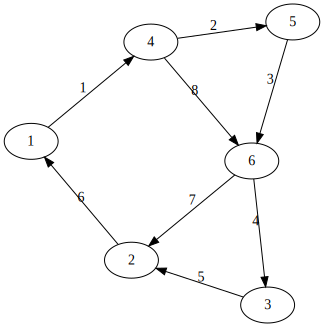

In [6]:
g = DiGraph(6, [1=>4, 4=>5, 5=>6, 6=>3, 3=>2, 2=>1, 6=>2, 4=>6])

In [7]:
A = incidence(g)

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   1   0   0  -1
  0   1  -1   0   0   0
  1  -1   0   0   0   0
  0   1   0   0   0  -1
  0   0   0  -1   0   1

In [8]:
rank(A)

5

In [9]:
# Pkg.add("RowEchelon") # uncomment this to install
using RowEchelon

In [10]:
Matrix{Int}(rref(A'))

6×8 Array{Int64,2}:
 1  0  0  0  0  -1  0  0
 0  1  0  0  0  -1  0  1
 0  0  1  0  0  -1  0  1
 0  0  0  1  0  -1  1  0
 0  0  0  0  1  -1  1  0
 0  0  0  0  0   0  0  0

In [11]:
# Find the loops in g by the simplest "textbook" manner:
# get a basis for the nullspace of the transpose of the incidence matrix.
# We do this via the rref form, rather than nullspace(A'), because
# we want a "nice" basis of ±1 and 0 entries.
function loops(g::DiGraph)
    A = incidence(g)
    R = rref(A')
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(R[i,:])
        j > 0 && push!(pivots, j)
    end
    r = length(pivots) # rank
    free = Int[j for j=1:n if j ∉ pivots]
    N = zeros(Int, n, n-r)
    k = 0
    for (k,j) in enumerate(free)
        N[pivots, k] = -R[1:r, j]
        N[j, k] = 1
    end
    return N
end

loops (generic function with 1 method)

In [12]:
loops(g)

8×3 Array{Int64,2}:
 1   0   0
 1   0  -1
 1   0  -1
 1  -1   0
 1  -1   0
 1   0   0
 0   1   0
 0   0   1

In [13]:
using Interact

function animloops(g::DiGraph)
    L = loops(g)
    @manipulate for loop in 1:size(L,2)
        coloredges(coloredges(g, find(L[:,loop] .== 1), "red"), find(L[:,loop] .== -1), "blue")
    end
end

animloops (generic function with 1 method)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(2, nactions=1),"loop",2,"2",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3),Dict(2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

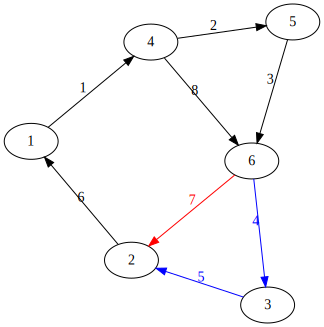

In [14]:
animloops(g)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(12, nactions=1),"loop",12,"12",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",2=>"2",16=>"16",11=>"11",21=>"21",7=>"7",9=>"9",10=>"10",19=>"19",17=>"17"…)),Any[],Any[],true,"horizontal")

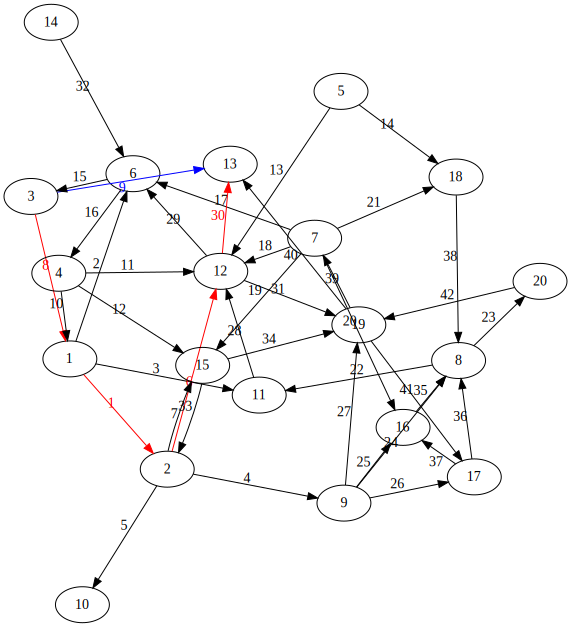

In [15]:
animloops(randgraph(20, 2))

In [16]:
function colortree(g::DiGraph)
    A = incidence(g)
    R = rref(A')
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(R[i,:])
        j > 0 && push!(pivots, j)
    end
    coloredges(g, pivots)
end

colortree (generic function with 1 method)

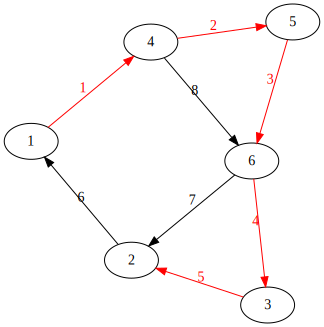

In [17]:
colortree(g)

In [18]:
tree(g)

LoadError: UndefVarError: tree not defined

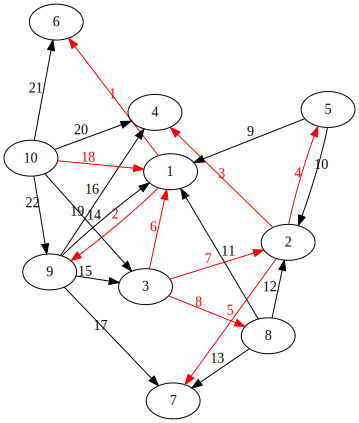

In [19]:
colortree(randgraph(10, 2))

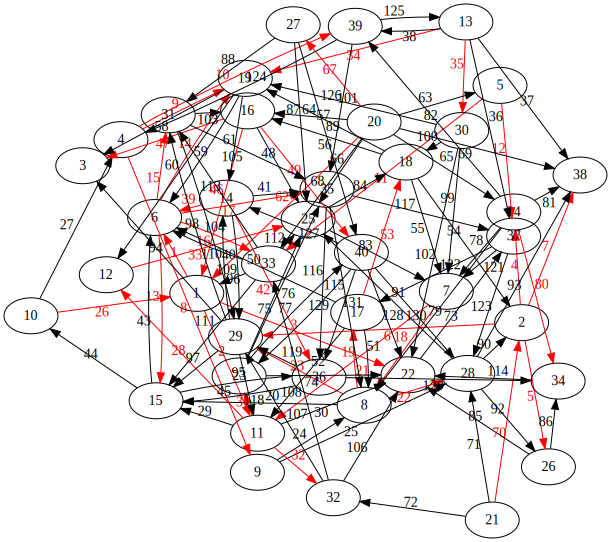

In [20]:
colortree(randgraph(40, 3))

In [21]:
function tree(g::DiGraph)
    A = incidence(g)
    R = rref(A')
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(R[i,:])
        j > 0 && push!(pivots, j)
    end
    DiGraph(copy(g.nodelabels), g.edges[pivots], g.edgelabels[pivots],
            copy(g.nodecolors), g.edgecolors[pivots])
end

tree (generic function with 1 method)

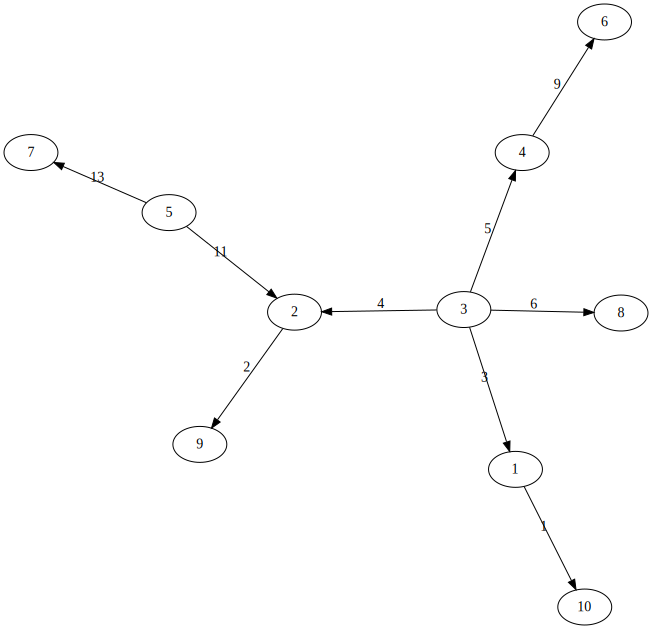

In [22]:
tree(randgraph(10, 3))

In [23]:
using SymPy

In [24]:
v = [Sym("v_$i") for i = 1:size(A,2)]

6-element Array{SymPy.Sym,1}
[v_1]
[   ]
[v_2]
[   ]
[v_3]
[   ]
[v_4]
[   ]
[v_5]
[   ]
[v_6]

In [25]:
A

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   1   0   0  -1
  0   1  -1   0   0   0
  1  -1   0   0   0   0
  0   1   0   0   0  -1
  0   0   0  -1   0   1

In [26]:
A * v

8-element Array{SymPy.Sym,1}
[-v_1 + v_4]
[          ]
[-v_4 + v_5]
[          ]
[-v_5 + v_6]
[          ]
[v_3 - v_6 ]
[          ]
[v_2 - v_3 ]
[          ]
[v_1 - v_2 ]
[          ]
[v_2 - v_6 ]
[          ]
[-v_4 + v_6]

In [27]:
# convert strings like "v_2 - v_0" from SymPy to nicer Unicode strings like "v₂ - v₀"
subchar(d::Integer) = Char(UInt32('₀')+d)
subchar(c::Char) = subchar(UInt32(c)-UInt32('0'))
subchar(s::String) = replace(s, r"_[0-9]", s -> subchar(s[2]))
subchar(s::SymPy.Sym) = subchar(stringmime("text/plain", s))
subchar("v_2 - v_0")

"v₂ - v₀"

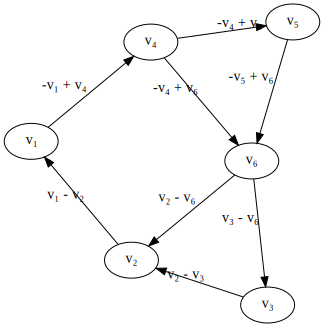

In [28]:
glabeled = copy(g)
glabeled.edgelabels = subchar.(A*v)
glabeled.nodelabels = subchar.(v)
glabeled

In [29]:
Y = diagm([Sym("Y_$i") for i = 1:size(A,1)])

8×8 Array{SymPy.Sym,2}
[Y_1   0    0    0    0    0    0    0 ]
[                                      ]
[ 0   Y_2   0    0    0    0    0    0 ]
[                                      ]
[ 0    0   Y_3   0    0    0    0    0 ]
[                                      ]
[ 0    0    0   Y_4   0    0    0    0 ]
[                                      ]
[ 0    0    0    0   Y_5   0    0    0 ]
[                                      ]
[ 0    0    0    0    0   Y_6   0    0 ]
[                                      ]
[ 0    0    0    0    0    0   Y_7   0 ]
[                                      ]
[ 0    0    0    0    0    0    0   Y_8]

In [30]:
A' * Y * A

6×6 Array{SymPy.Sym,2}
[Y_1 + Y_6       -Y_6            0           -Y_1            0                
[                                                                             
[  -Y_6     Y_5 + Y_6 + Y_7    -Y_5            0             0              -Y
[                                                                             
[    0           -Y_5        Y_4 + Y_5         0             0              -Y
[                                                                             
[  -Y_1            0             0      Y_1 + Y_2 + Y_8    -Y_2             -Y
[                                                                             
[    0             0             0           -Y_2        Y_2 + Y_3          -Y
[                                                                             
[    0           -Y_7          -Y_4          -Y_8          -Y_3     Y_3 + Y_4 

0          ]
           ]
_7         ]
           ]
_4         ]
           ]
_8         ]
           ]
_3 